In [3]:
!rm -rf ~/.kaggle
!rm kaggle.json

In [4]:
!ls

'kaggle (1).json'   sample_data


In [8]:
!mv "kaggle (1).json" kaggle.json

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets list -s covid

ref                                                   title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
imdevskp/corona-virus-report                          COVID-19 Dataset                                       19921674  2020-08-07 03:47:47.907000         417047       2778  1.0              
meirnizri/covid19-dataset                             COVID-19 Dataset                                        4890659  2022-11-13 15:47:17.437000          69101        873  1.0              
sudalairajkumar/covid19-in-india                      COVID-19 in India                                        776022  2021-08-11 04:14:10.130000         308997       2101  0.9117647        
tawsifurrahman/covid19-radiography-database  

In [11]:
!kaggle datasets download -d preetviradiya/covid19-radiography-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/covid19-radiography-dataset
License(s): GPL-2.0
 89% 661M/747M [00:06<00:01, 52.3MB/s]
100% 747M/747M [00:06<00:00, 113MB/s] 


In [12]:
import zipfile

with zipfile.ZipFile('covid19-radiography-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [13]:
import os
os.listdir()

['.config',
 'COVID-19_Radiography_Dataset',
 'covid19-radiography-dataset.zip',
 'kaggle.json',
 'metadata.csv',
 'sample_data']

In [15]:
os.listdir('COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset')

['Viral Pneumonia', 'COVID', 'Lung_Opacity', 'Normal']

In [18]:
from sklearn.model_selection import train_test_split
import shutil
import os

base_dir = 'COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
new_base = 'covid_binary'

os.makedirs(new_base+'/train/COVID', exist_ok=True)
os.makedirs(new_base+'/train/NORMAL', exist_ok=True)
os.makedirs(new_base+'/test/COVID', exist_ok=True)
os.makedirs(new_base+'/test/NORMAL', exist_ok=True)

In [20]:
covid_files = os.listdir(base_dir+'/COVID')[:1500]
normal_files = os.listdir(base_dir+'/Normal')[:1500]

In [21]:
covid_train, covid_test = train_test_split(
    covid_files, test_size=0.2, random_state=42
)

normal_train, normal_test = train_test_split(
    normal_files, test_size=0.2, random_state=42
)

In [22]:
for file in covid_train:
    shutil.copy(base_dir+'/COVID/'+file, new_base+'/train/COVID/'+file)

for file in covid_test:
    shutil.copy(base_dir+'/COVID/'+file, new_base+'/test/COVID/'+file)

for file in normal_train:
    shutil.copy(base_dir+'/Normal/'+file, new_base+'/train/NORMAL/'+file)

for file in normal_test:
    shutil.copy(base_dir+'/Normal/'+file, new_base+'/test/NORMAL/'+file)

In [23]:
!ls covid_binary/train
!ls covid_binary/test

COVID  NORMAL
COVID  NORMAL


In [43]:
len(os.listdir('covid_binary/train/COVID'))

1200

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'covid_binary/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'covid_binary/test',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=3
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7620 - loss: 0.4817 - val_accuracy: 0.8483 - val_loss: 0.3464
Epoch 2/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8878 - loss: 0.2657 - val_accuracy: 0.9100 - val_loss: 0.2430
Epoch 3/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9253 - loss: 0.1875 - val_accuracy: 0.9267 - val_loss: 0.2209


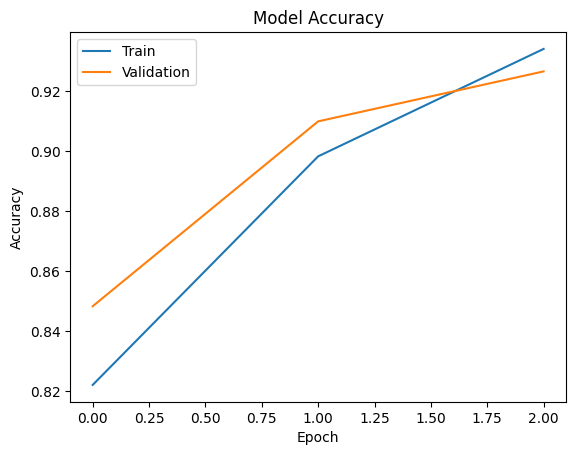

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score

y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

y_true = test_generator.classes

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nF1 Score:", f1_score(y_true, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
Confusion Matrix:
 [[279  21]
 [ 23 277]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       300
           1       0.93      0.92      0.93       300

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600


F1 Score: 0.9264214046822743


In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

# IMPORTANT: reset generator before predicting again
test_generator.reset()

y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Accuracy: 0.9266666666666666
F1 Score: 0.9264214046822743

Confusion Matrix:
 [[279  21]
 [ 23 277]]


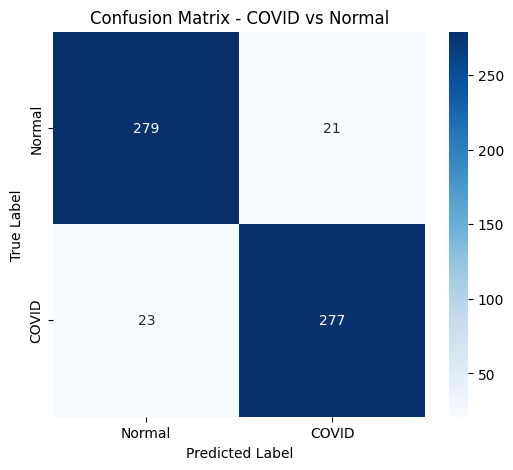

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'COVID'],
    yticklabels=['Normal', 'COVID']
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - COVID vs Normal')
plt.show()

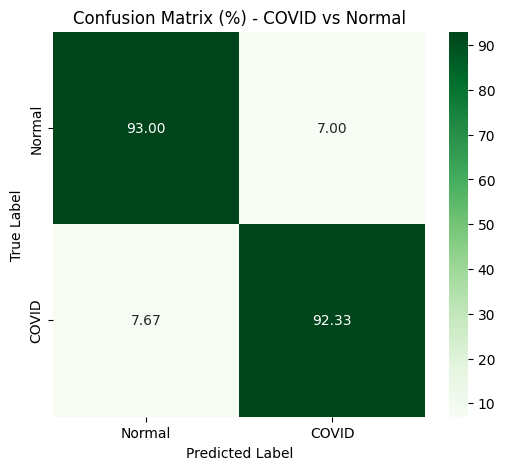

In [36]:
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,5))

sns.heatmap(
    cm_percent,
    annot=True,
    fmt='.2f',
    cmap='Greens',
    xticklabels=['Normal', 'COVID'],
    yticklabels=['Normal', 'COVID']
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) - COVID vs Normal')
plt.show()

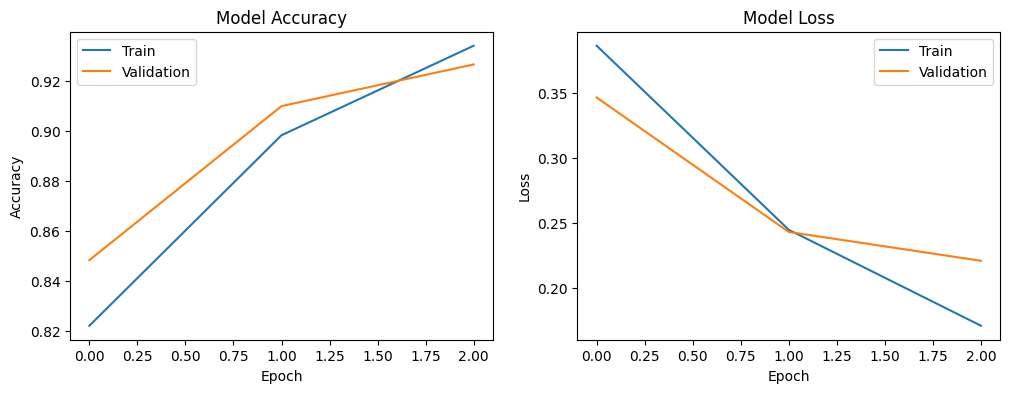

In [37]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [38]:
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity (Recall for COVID):", sensitivity)
print("Specificity (Normal detection rate):", specificity)

Sensitivity (Recall for COVID): 0.9233333333333333
Specificity (Normal detection rate): 0.93


In [44]:
model.save("covid_mobilenet_model.keras")

In [45]:
!ls

binary_dataset			 covid_binary		      metadata.csv
COVID-19_Radiography_Dataset	 covid_mobilenet_model.keras  sample_data
covid19-radiography-dataset.zip  kaggle.json


In [46]:
from google.colab import files
files.download("covid_mobilenet_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
import json

with open("training_history.json", "w") as f:
    json.dump(history.history, f)

In [48]:
files.download("training_history.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>